# Unbiasing COVID-19 Case Count
Kartik Chugh - May 3, 2020

In [20]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import Image

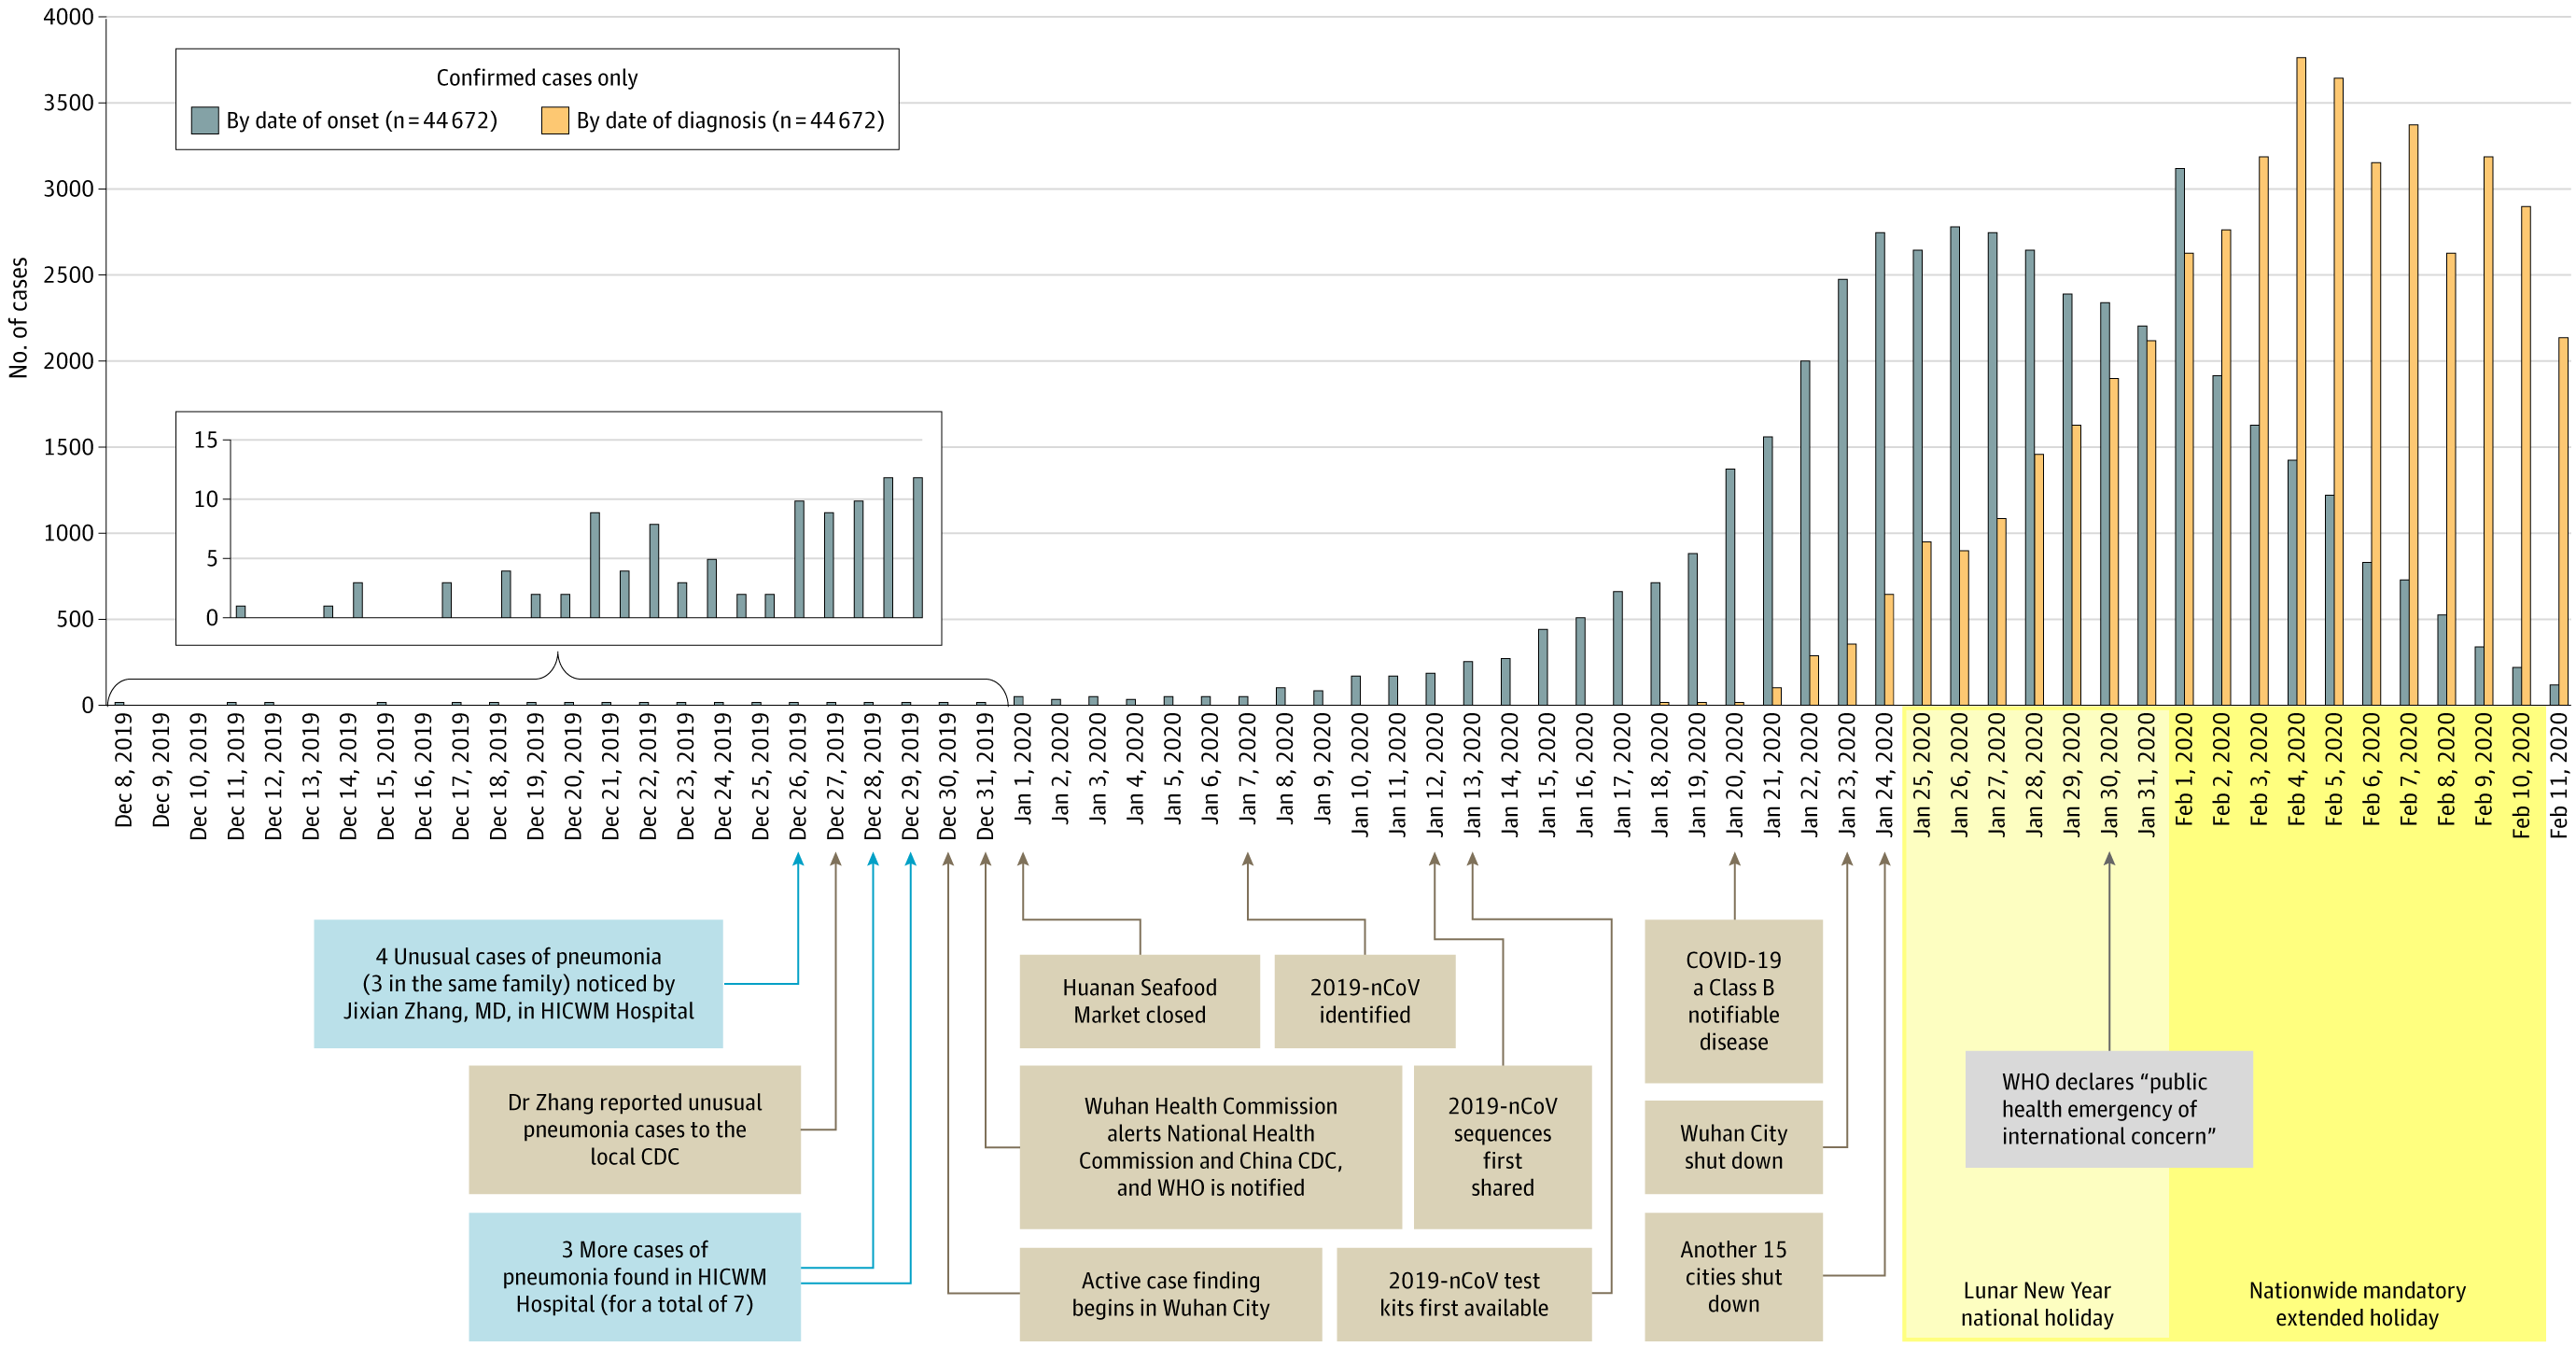

In [23]:
Image('china-data.png')

In [15]:
url = 'https://covidtracking.com/api/v1/us/daily.csv'
pd.read_csv(url, 
            usecols=['date', 'positive'], 
            parse_dates=['date'], 
            index_col=['date'], squeeze=True).sort_index()

date
2020-01-22          1
2020-01-23          1
2020-01-24          1
2020-01-25          1
2020-01-26          1
               ...   
2020-04-28    1005592
2020-04-29    1033157
2020-04-30    1062134
2020-05-01    1095681
2020-05-02    1125719
Name: positive, Length: 102, dtype: int64